In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import KFold
import scipy.io as sio
import seaborn as sns
import scipy.optimize
import pickle
import pandas as pd
sns.set_context("talk")

# Import outside packages by changing the path
import sys, os
sys.path.append(os.path.abspath(os.path.join('..', '..', 'glmhmm')))
from glmhmm import glm, glm_hmm, utils, analysis
from glmhmm.utils import permute_states, find_best_fit, compare_top_weights
from glmhmm import visualize

# code from Brody Summer Project
sys.path.append(os.path.abspath(os.path.join('..', '..', 'LC_PWM_GLM-HMM/code')))
import io_utils, analysis_utils, plotting_utils

sns.set_context("talk")

In [6]:
### Fitting Iris' standard GLM-HMM models for IBL 3 features data for each animal from witten lab and until session 40

In [3]:
ibl_data_path = '../data_IBL'
dfAll = pd.read_csv(ibl_data_path + '/Ibl_processed.csv')
subjectsWitten = np.unique(dfAll[dfAll['lab'] == 'wittenlab']['subject'])
print(subjectsWitten)

['ibl_witten_02' 'ibl_witten_03' 'ibl_witten_04' 'ibl_witten_05'
 'ibl_witten_06' 'ibl_witten_07' 'ibl_witten_12' 'ibl_witten_13'
 'ibl_witten_14' 'ibl_witten_15' 'ibl_witten_16']


In [11]:
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

def get_mouse_design(dfAll, subject):
    data = dfAll[dfAll['subject']==subject]   # Restrict data to the subject specified

    p=5 # as used in Psytrack paper
    data['cL'] = np.tanh(p*data['contrastLeft'])/np.tanh(p) # tanh transformation of left contrasts
    data['cR'] = np.tanh(p*data['contrastRight'])/np.tanh(p) # tanh transformation of right contrasts

    # keeping first 40 sessions
    dateToKeep = np.unique(data['date'])[0:40]
    dataTemp = pd.DataFrame(data.loc[data['date'].isin(list(dateToKeep))])

    # design and out matrix
    x = np.ones((dataTemp.shape[0], 3)) # column 0 is bias
    x[:,1] = dataTemp['cL'] # cL = contrast left transformed 
    x[:,2] = dataTemp['cR'] # cR = contrast right transformed
    y = np.array(dataTemp['choice'])
    print(y.shape)

    # session start indicies
    sessInd = [0]
    for date in dateToKeep :
        d = dataTemp[dataTemp['date']==date]
        for sess in np.unique(d['session']):
            dTemp = d[d['session'] == sess] 
            dLength = len(dTemp.index.tolist())
            sessInd.append(sessInd[-1] + dLength)
    print(sessInd[-1])
    
    return x, y, sessInd

In [21]:
subject = 'ibl_witten_15'
x, y, sessInd = get_mouse_design(dfAll, subject)

for K in [3]:

    # Set hyperparameters
    N = x.shape[0] # number of data/time points for the indirect pathway cohort
    C = 2 # number of observation classes
    D = x.shape[1] # number of GLM inputs (regressors)

    inits = 30 # set the number of initializations - Iris has 50
    maxiter = 250 # maximum number of iterations of EM to allow for each fit - Iris has 250
    tol = 1e-4

    # store values for each initialization
    lls_all = np.zeros((inits,maxiter))
    real_GLMHMMs = np.zeros((inits),dtype=object)

    # fit the model for each initialization
    for i in range(inits):
        print("Init ", i)
        real_GLMHMMs[i] = glm_hmm.GLMHMM(N,D,C,K,observations="bernoulli",gaussianPrior=1)
        # initialize the weights
        A_init, w_init, _ = real_GLMHMMs[i].generate_params(weights=['GLM',-2,2.2,x,y,1])
        # fit the model                     
        lls_all[i,:], A, w, pi = real_GLMHMMs[i].fit(y,x,A_init,w_init,maxiter=maxiter,tol=tol,sess=sessInd) 
        
        # Check to see that multiple fits achieve the same log-likelihood 
    fig, axes = plt.subplots(1,1)
    fig.set_size_inches(8, 4)
    topixs = visualize.plot_loglikelihoods(lls_all, maxdiff=0.15, ax=axes, startix=5) # colored in red are the ones (within maxdiff) to the best
    axes.set_title('log like')
        

    # find the initialization that led to the best fit
    bestix = find_best_fit(lls_all) 
    best_GLMHMM = real_GLMHMMs[bestix]

    # save the best fit - only for when large number of initializations and iterations!
    pickle.dump(best_GLMHMM, open(f'../data_IBL/IBL_{subject}_bestGLMHMM__states-' + str(K) + '.pickle', 'wb'))

(36672,)
36672
Init  0
Init  1
Init  2
Init  3
Init  4
Init  5
Init  6
Init  7
Init  8
Init  9
Init  10
Init  11
Init  12


[ 1  3  5 14 18 19 20 24]
[[[ 0.          2.80691371]
  [ 0.         -2.83475789]
  [ 0.         -0.90271782]]

 [[ 0.         -0.38889616]
  [ 0.         -2.49361159]
  [ 0.          1.84860961]]]


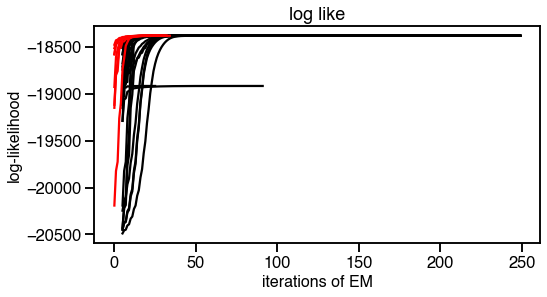

In [20]:
fig, axes = plt.subplots(1,1)
fig.set_size_inches(8, 4)
topixs = visualize.plot_loglikelihoods(lls_all[0:25], maxdiff=0.15, ax=axes, startix=5) # colored in red are the ones (within maxdiff) to the best
axes.set_title('log like')
print(topixs)

# find the initialization that led to the best fit
bestix = find_best_fit(lls_all[0:25]) 
best_GLMHMM = real_GLMHMMs[bestix]
print(best_GLMHMM.w)

In [ ]:
subject = 'ibl_witten_16'
x, y, sessInd = get_mouse_design(dfAll, subject)

for K in [2,3]:

    # Set hyperparameters
    N = x.shape[0] # number of data/time points for the indirect pathway cohort
    C = 2 # number of observation classes
    D = x.shape[1] # number of GLM inputs (regressors)

    inits = 30 # set the number of initializations - Iris has 50
    maxiter = 250 # maximum number of iterations of EM to allow for each fit - Iris has 250
    tol = 1e-4

    # store values for each initialization
    lls_all = np.zeros((inits,maxiter))
    real_GLMHMMs = np.zeros((inits),dtype=object)

    # fit the model for each initialization
    for i in range(inits):
        print("Init ", i)
        real_GLMHMMs[i] = glm_hmm.GLMHMM(N,D,C,K,observations="bernoulli",gaussianPrior=1)
        # initialize the weights
        A_init, w_init, _ = real_GLMHMMs[i].generate_params(weights=['GLM',-2,2.2,x,y,1])
        # fit the model                     
        lls_all[i,:], A, w, pi = real_GLMHMMs[i].fit(y,x,A_init,w_init,maxiter=maxiter,tol=tol,sess=sessInd) 
        
        # Check to see that multiple fits achieve the same log-likelihood 
    fig, axes = plt.subplots(1,1)
    fig.set_size_inches(8, 4)
    topixs = visualize.plot_loglikelihoods(lls_all, maxdiff=0.15, ax=axes, startix=5) # colored in red are the ones (within maxdiff) to the best
    axes.set_title('log like')
        

    # find the initialization that led to the best fit
    bestix = find_best_fit(lls_all) 
    best_GLMHMM = real_GLMHMMs[bestix]

    # save the best fit - only for when large number of initializations and iterations!
    pickle.dump(best_GLMHMM, open(f'../data_IBL/IBL_{subject}_bestGLMHMM__states-' + str(K) + '.pickle', 'wb'))

In [ ]:
for subjects in ['ibl_witten_15','ibl_witten_16']:
    for K in [2,3]:
        bestGLMHMM = pickle.load(open(f'../data_IBL/IBL_{subject}_bestGLMHMM__states-' + str(K) + '.pickle', 'rb'))
        print(bestGLMHMM.A)

        x, y, sessInd = get_mouse_design(dfAll, subject)
        wTemp = bestGLMHMM.w
        wTemp[:,:,:] = - wTemp[:,:,:] # all weights have opposite sign in my code vs Iris'
        w = np.repeat(wTemp[np.newaxis], sessInd[-1], axis=0)
        np.save(f'../data_IBL/W_IBL_{subject}_bestGLMHMM-Iris_{K}-state', w)
        np.save(f'../data_IBL/P_IBL_{subject}_bestGLMHMM-Iris_{K}-state', bestGLMHMM.A)